# Dynamic Programming

## Définition

Reference: https://www.davidsilver.uk/wp-content/uploads/2020/03/DP.pdf3

 - Connaissance complète du MDP. Etant donné un MDP, on peut utiliser les algorithmes de programmation dynamiques pour trouver la politique optimale 𝜋^* qui maximise le retour G
 - Prediction
   * Input: MDP <S, A, P, R, 𝛾> et une politique / MRP <S, P^𝜋, R^𝜋, 𝛾>
   * Output:  value function v_𝜋
 - Control
   * Input: MDP <S, A, P, R, 𝛾> 
   * Output: optimal value function v* et policy 𝜋*
 
### Relation de récurrence / Equation de Bellman / Bellman Expectation Equation (MDP)

The state-value function can again be decomposed into immediate
reward plus discounted value of successor state

$
v_\pi(s) = \mathbb{E}[R_{t+1} + \gamma v_\pi(S_{t+1}) / S_t = s] \\
v_\pi(s) = \sum_{a \in \mathcal{A}} \pi(a/s) q_\pi(s,a) \\
q_\pi(s,a) = \mathcal{R}^a_s + \gamma \sum_{s \in S} \mathcal{P}^a_{ss'} v_\pi(s')
$

On a donc:

$
v_{k+1}(s) = \sum_{a\in \mathcal{A}} \pi(a/s) (\mathcal{R}^a_s + \gamma \sum_{s \in S} \mathcal{P}^a_{ss'} v_k(s'))
$

Avec:
 - $\mathcal{R}^a_s = \mathbb{E}[R_{t+1} / S_t = s, A_t = a]$
 - $\mathcal{P}^a_{ss'} = \mathbb{P}[S_{t+1} = s' / S_t = s, A_t = a]$

Dans Small World, on suppose que $\mathcal{R}^a_s = -1$ (0 pour les états terminaux) et $\mathcal{P}^a_{ss'} = 0.25$

### Policy Iteration / Amélioration de la politique

On démarre d'une politique π qu'on améliore de manière itérative. L'algorithme est le suivant:

_Répéter jusqu'à convergence_:
 - **Evaluation** de la politique π par l'estimation de la fonction valeur v (policy evaluation)
 - **Amélioration** gloutonne (*greedy*): $\pi' = argmax_{a \in \mathcal{A}} q_\pi(s, a), \pi' \ge \pi$ (policy improvement)



In [1]:
import numpy as np
from random import random
import seaborn as sns

In [2]:
nb_columns = 4
nb_rows = 4

In [3]:
actions = [
    np.array([0, 1]),
    np.array([1, 0]),
    np.array([0, -1]),
    np.array([-1, 0])
]

nb_actions = len(actions)

terminal_states = [(0, 0), (nb_rows - 1, nb_columns - 1)]

v = np.zeros((nb_rows, nb_columns))

# Undiscounted episodic MDP
γ = 1
P = 0.25

def reward(new_state):
    return 0 if new_state in terminal_states else -1

R = np.zeros((nb_rows, nb_columns))
for x in range(nb_rows):
    for y in range(nb_columns):
        R[x, y] = reward((x, y))

def step(state, action):
    x, y = state + action
    new_x = max(0, min(x, nb_rows - 1))
    new_y = max(0, min(y, nb_columns - 1))
    return (new_x, new_y)

def update_v(v, π):
    nb_rows, nb_columns = v.shape
    v_p = np.zeros(v.shape)
    for x in range(nb_rows):
        for y in range(nb_columns):
            s = (x, y)
            v_p[s] = sum([π[s + (a_i,)] * (R[s] + γ * sum([P * v[step(s, ap)] for ap in actions])) for a_i in range(nb_actions)])
    return v_p

def update_policy_greedy(v):
    nb_rows, nb_columns = v.shape
    π_p = np.zeros((nb_rows, nb_columns, nb_actions))
    for x in range(nb_rows):
        for y in range(nb_columns):
            s = (x, y)
            v_s = [v[step(s, ap)] for ap in actions]
            optimal_v = max(v_s)
            optimal_actions = v_s == optimal_v
            π_p[s] = optimal_actions / sum(optimal_actions)
    return π_p


In [7]:
π = np.zeros((nb_rows, nb_columns, nb_actions))

# Agent follows uniform random policy
# P(a/s) = 1/|A|
π.fill(1/nb_actions)


v = update_v(v, π)
πp = update_policy_greedy(v)

while not (πp == π).all():
    πp = π
    # Evaluate the policy
    v = update_v(v, π)
    # Improve the policy
    π = update_policy_greedy(v)

In [9]:
π, v

(array([[[0. , 0. , 0.5, 0.5],
         [0. , 0. , 1. , 0. ],
         [0. , 0. , 1. , 0. ],
         [0. , 0.5, 0.5, 0. ]],
 
        [[0. , 0. , 0. , 1. ],
         [0. , 0. , 0.5, 0.5],
         [0. , 0.5, 0.5, 0. ],
         [0. , 1. , 0. , 0. ]],
 
        [[0. , 0. , 0. , 1. ],
         [0.5, 0. , 0. , 0.5],
         [0.5, 0.5, 0. , 0. ],
         [0. , 1. , 0. , 0. ]],
 
        [[0.5, 0. , 0. , 0.5],
         [1. , 0. , 0. , 0. ],
         [1. , 0. , 0. , 0. ],
         [0.5, 0.5, 0. , 0. ]]]),
 array([[-2.609375, -4.21875 , -4.78125 , -4.921875],
        [-4.21875 , -4.640625, -4.828125, -4.78125 ],
        [-4.78125 , -4.828125, -4.640625, -4.21875 ],
        [-4.921875, -4.78125 , -4.21875 , -2.609375]]))

In [10]:
min_v = min(v.reshape(-1))
max_v = max(v.reshape(-1))
normalize_v = (v - min_v) / (max_v - min_v)
normalize_v

array([[1.        , 0.30405405, 0.06081081, 0.        ],
       [0.30405405, 0.12162162, 0.04054054, 0.06081081],
       [0.06081081, 0.04054054, 0.12162162, 0.30405405],
       [0.        , 0.06081081, 0.30405405, 1.        ]])

<AxesSubplot:>

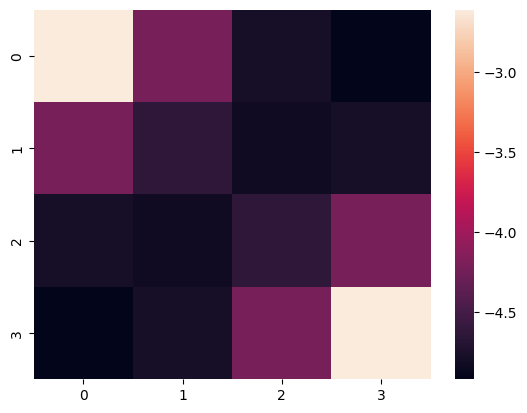

In [11]:
sns.heatmap(v)

### Value Iteration

On cherche à trouver la fonction valeur optimale v* en améliorant de manière itérative v.

$
v^* \leftarrow \max_{a \in \mathcal{A}} \mathcal{R}^a_s + \gamma \sum_{s' \in S} \mathcal{P}^a_{ss'} v^*(s')
$

 - policy extraction

(array([[ 0.        , -1.        , -1.25      , -1.3125    ],
        [-1.        , -1.5       , -1.6875    , -1.75      ],
        [-1.25      , -1.6875    , -1.84375   , -1.8984375 ],
        [-1.3125    , -1.75      , -1.8984375 , -1.94921875]]),
 <AxesSubplot:>)

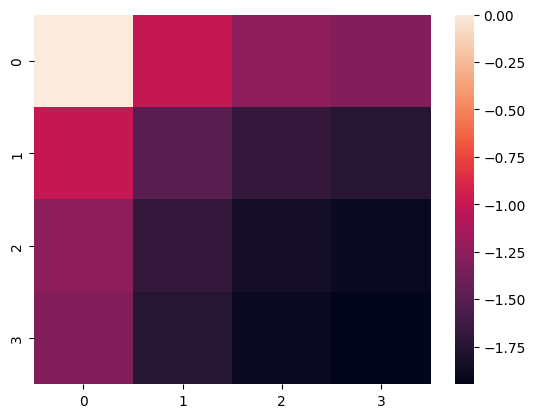

In [13]:
v = np.zeros((nb_rows, nb_columns))

θ = 1e-4
Δ = 0

def reward2(new_state):
    return 0 if new_state == (0,0) else -1

while Δ < θ:
    for x in range(nb_rows):
        for y in range(nb_columns):
            s = (x, y)
            v_s = v[s]
            v[s] = max([reward2(s) + γ * sum([P * v[step(s, ap)] for ap in actions]) for a in range(nb_actions)])
            Δ = max(Δ, abs(v_s - v[s]))

π = update_policy_greedy(v)

v, sns.heatmap(v)